In [1]:
%load_ext autoreload
%autoreload 2

import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from seqme import ModelCache, compute_metrics, show_table
from seqme.metrics import FBD, ID, MMD, Fold, Novelty, Precision, Recall, Uniqueness, AuthPct
from seqme.models import Esm2, Esm2Checkpoint, HydrAMPModel, VAETransformerModel
from seqme.plots import plot_embeddings, plot_kde, tsne
from seqme.utils import random_subset, read_fasta_file, shuffle_sequences

from config_paths import PATHS_FOR_CONTROL, PATHS_FOR_MODELS

/raid/brunopsz/Hackaton/pepme/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda:3'

In [4]:
datasets = {name: read_fasta_file(path) for name, path in (PATHS_FOR_CONTROL | PATHS_FOR_MODELS).items()}

In [5]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

positives: 14941 sequences
positives_hq: 3322 sequences
negatives: 14814 sequences
negatives_hq: 925 sequences
random_uniform: 50000 sequences
random_standard: 50000 sequences
UniProt: 50000 sequences
AMP-Diffusion: 47671 sequences
AMP-GAN: 50000 sequences
CPL-Diff: 46305 sequences
HydrAMP: 50000 sequences
OmegAMP: 50000 sequences
AMP-LM: 25608 sequences
AMP-Muller: 1052 sequences


In [6]:
CACHE_PATH = "../cache.pkl"

if CACHE_PATH:
    with open(CACHE_PATH, "rb") as f:
        init_cache = pickle.load(f)
else:
    init_cache = None

In [ ]:
esm2 = Esm2(
    model_name=Esm2Checkpoint.t33_650M,
    batch_size=64,
    device=device,
    verbose=False,
)

esm2_finetuned = Esm2(
    model_name="../src/seqme/models/esm_finetuned",
    batch_size=64,
    device=device,
    verbose=False,
)

hydramp = HydrAMPModel(
    device=device,
    batch_size=128,
)

vae_transformer = VAETransformerModel(batch_size=128)

cache = ModelCache(
    models={
        "esm2-embed": esm2.embed,
        "esm2-pretrain": esm2_finetuned.embed,
        "hydramp-embed": hydramp.embed,
        "vae_transformer-embed": vae_transformer.embed, 
    },
    init_cache=init_cache,
)

In [8]:
sources = [
    "positives",
    "positives_hq",
    "negatives",
    #"negatives_hq",
    "random_uniform",
    "random_standard",
    "UniProt",
    "AMP-Diffusion",
    "AMP-GAN",
    "CPL-Diff",
    "HydrAMP",
    "OmegAMP",
    "AMP-LM",
    # "AMP-Muller",
]

n_samples = 50_000
seed = 42

benchmark_datasets = {
    source: random_subset(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}
seqs_ref = datasets["positives_hq"]

In [9]:
init_cache.keys()

dict_keys(['esm2-embed', 'esm2-pretrain', 'esm2_pseudo_perplexity', 'esm2-pretrain_pseudo_perplexity', 'hydramp-embed', 'vae_transformer-embed'])

In [ ]:
esm = "esm2-embed"
esm_finetuned = "esm2-pretrain"
hydramp_model = "hydramp-embed"
vae_transformer_model = "vae_transformer-embed"

metrics = [
    Uniqueness(),
    Novelty(reference=seqs_ref),
    FBD(reference=seqs_ref, embedder=cache.model(esm), embedder_name=esm),
    FBD(reference=seqs_ref, embedder=cache.model(esm_finetuned), embedder_name=esm_finetuned),
    FBD(reference=seqs_ref, embedder=cache.model(hydramp_model), embedder_name=hydramp_model),
    FBD(reference=seqs_ref, embedder=cache.model(vae_transformer_model), embedder_name=vae_transformer_model),
    MMD(reference=seqs_ref, embedder=cache.model(esm), device="cpu", embedder_name=esm),
    MMD(reference=seqs_ref, embedder=cache.model(esm_finetuned), device="cpu", embedder_name=esm_finetuned),
    MMD(reference=seqs_ref, embedder=cache.model(hydramp_model), device="cpu", embedder_name=hydramp_model),
    MMD(reference=seqs_ref, embedder=cache.model(vae_transformer_model), device="cpu", embedder_name=vae_transformer_model),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm), strict=True, device=device, embedder_name=esm
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm), strict=True, device=device, embedder_name=esm),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm_finetuned), strict=True, device=device, embedder_name=esm_finetuned
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm_finetuned), strict=True, device=device, embedder_name=esm_finetuned),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(hydramp_model), strict=True, device=device, embedder_name=hydramp_model
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(hydramp_model), strict=True, device=device, embedder_name=hydramp_model),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(vae_transformer_model), strict=True, device=device, embedder_name=vae_transformer_model
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(vae_transformer_model), strict=True, device=device, embedder_name=vae_transformer_model),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
]

In [11]:
df = compute_metrics(benchmark_datasets, metrics)

 46%|████▌     | 11/24 [00:00<00:00, 538.03it/s, data=UniProt, metric=Novelty]          

100%|██████████| 24/24 [00:00<00:00, 259.37it/s, data=AMP-LM, metric=Novelty]          

Novel sequences: 14329/14941 (95.90%)
Novel sequences: 0/3322 (0.00%)
Novel sequences: 14814/14814 (100.00%)
Novel sequences: 50000/50000 (100.00%)
Novel sequences: 49999/50000 (100.00%)
Novel sequences: 50000/50000 (100.00%)
Novel sequences: 47671/47671 (100.00%)
Novel sequences: 50000/50000 (100.00%)
Novel sequences: 46134/46305 (99.63%)
Novel sequences: 50000/50000 (100.00%)
Novel sequences: 49252/50000 (98.50%)
Novel sequences: 25588/25608 (99.92%)


In [12]:
show_table(df, color=None)

,Uniqueness↑,Novelty↑
positives,1.00,0.96
positives_hq,1.00,0.00
negatives,1.00,1.00
random_uniform,1.00,1.00
random_standard,1.00,1.00
UniProt,1.00,1.00
AMP-Diffusion,0.91,1.00
AMP-GAN,1.00,1.00
CPL-Diff,0.97,1.00
HydrAMP,1.00,1.00


In [18]:
OUT_CACHE_PATH = "../cache.pkl"

with open(OUT_CACHE_PATH, "wb") as f:
    pickle.dump(cache.get(), f)

In [14]:
sources = [
    "negatives_hq",
    "AMP-Muller"
]

n_samples = len(datasets["AMP-Muller"])
seed = 42

benchmark_datasets = {
    source: random_subset(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}
seqs_ref = random_subset(datasets["positives_hq"], n_samples=n_samples, seed=seed)

In [ ]:
esm = "esm2-embed"
esm_finetuned = "esm2-pretrain"
hydramp_model = "hydramp-embed"
vae_transformer_model = "vae_transformer-embed"

metrics = [
    Uniqueness(),
    Novelty(reference=seqs_ref),
    FBD(reference=seqs_ref, embedder=cache.model(esm), embedder_name=esm),
    FBD(reference=seqs_ref, embedder=cache.model(esm_finetuned), embedder_name=esm_finetuned),
    FBD(reference=seqs_ref, embedder=cache.model(hydramp_model), embedder_name=hydramp_model),
    FBD(reference=seqs_ref, embedder=cache.model(vae_transformer_model), embedder_name=vae_transformer_model),
    MMD(reference=seqs_ref, embedder=cache.model(esm), device="cpu", embedder_name=esm),
    MMD(reference=seqs_ref, embedder=cache.model(esm_finetuned), device="cpu", embedder_name=esm_finetuned),
    MMD(reference=seqs_ref, embedder=cache.model(hydramp_model), device="cpu", embedder_name=hydramp_model),
    MMD(reference=seqs_ref, embedder=cache.model(vae_transformer_model), device="cpu", embedder_name=vae_transformer_model),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm), strict=True, device=device, embedder_name=esm
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm), strict=True, device=device, embedder_name=esm),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm_finetuned), strict=True, device=device, embedder_name=esm_finetuned
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(esm_finetuned), strict=True, device=device, embedder_name=esm_finetuned),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(hydramp_model), strict=True, device=device, embedder_name=hydramp_model
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(hydramp_model), strict=True, device=device, embedder_name=hydramp_model),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Precision(
            neighborhood_size=3, reference=seqs_ref, embedder=cache.model(vae_transformer_model), strict=True, device=device, embedder_name=vae_transformer_model
        ),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
    Fold(
        Recall(neighborhood_size=3, reference=seqs_ref, embedder=cache.model(vae_transformer_model), strict=True, device=device, embedder_name=vae_transformer_model),
        split_size=len(seqs_ref),
        drop_last=True,
    ),
]

In [16]:
df_negatives_hq = compute_metrics(benchmark_datasets, metrics)

100%|██████████| 4/4 [00:00<00:00, 1479.73it/s, data=AMP-Muller, metric=Novelty]   


In [22]:
OUT_CACHE_PATH = "../cache.pkl"

with open(OUT_CACHE_PATH, "wb") as f:
    pickle.dump(cache.get(), f)

In [17]:
df_negatives_hq

Uniqueness             Novelty          
                  value deviation     value deviation
negatives_hq   1.000000       NaN  1.000000       NaN
AMP-Muller     0.846958       NaN  0.990494       NaN

In [ ]:
import pandas as pd


row_to_insert = df_negatives_hq.loc[['negatives_hq']]

insert_pos = df.index.get_loc('negatives') + 1

df_new = pd.concat(
    [df.iloc[:insert_pos], row_to_insert, df.iloc[insert_pos:]]
)

row_muller = df_negatives_hq.loc[['AMP-Muller']]
df_new = pd.concat([df_new, row_muller])


In [19]:
show_table(df_new, color=None)

,Uniqueness↑,Novelty↑
positives,1.00,0.96
positives_hq,1.00,0.00
negatives,1.00,1.00
negatives_hq,1.00,1.00
random_uniform,1.00,1.00
random_standard,1.00,1.00
UniProt,1.00,1.00
AMP-Diffusion,0.91,1.00
AMP-GAN,1.00,1.00
CPL-Diff,0.97,1.00


In [ ]:
# df_new.to_csv("../final_results_max_len_40.csv")

In [30]:
len(datasets['negatives_hq'])

925

In [11]:
datasets_to_plot_names = [
    "positives",
    "positives_hq",
    "negatives",
    "negatives_hq",
    # "UniProt",
    # "random_uniform",
    # "AMP-Diffusion"
]

colors = ["#8490f5", "#fbbc04", "#68d6bc", "#f311d1",]#,"#aaaaaa"] #"#f9825bff",

n_samples = 2000
seed = 42

datasets_to_plot = {
    name: random_subset(datasets[name], n_samples=n_samples, seed=seed)
    if len(datasets[name]) > n_samples
    else datasets[name]
    for name in datasets_to_plot_names
}

In [ ]:
esm = "esm2-embed"
esm_finetuned = "esm2-pretrain"
hydramp_model = "hydramp-embed"
vae_transformer_model = "vae_transformer-embed"

In [ ]:
embedder_esm = cache.model(esm)
embedder_esm_finetuned = cache.model(esm_finetuned)
embedder_hydramp = cache.model(hydramp_model)
embedder_vae_transformer = cache.model(vae_transformer_model)

embeddings_esm = {
    name: embedder_esm(dataset) for name, dataset in datasets_to_plot.items()
}

embeddings_esm_finetuned = {
    name: embedder_esm_finetuned(dataset) for name, dataset in datasets_to_plot.items()
}

embeddings_hydramp = {
    name: embedder_hydramp(dataset) for name, dataset in datasets_to_plot.items()
}

embeddings_vae_transformer = {
    name: embedder_vae_transformer(dataset) for name, dataset in datasets_to_plot.items()
}

In [ ]:
from sklearn.metrics import silhouette_score

def compute_silhouette_score(embeddings_dict):
    X = np.vstack(list(embeddings_dict.values()))
    y = np.concatenate([[label] * len(arr) for label, arr in embeddings_dict.items()])
    score = silhouette_score(X, y, metric="euclidean")
    return score

score_esm = compute_silhouette_score(embeddings_esm)
score_esm_finetuned = compute_silhouette_score(embeddings_esm_finetuned)
score_hydramp = compute_silhouette_score(embeddings_hydramp)
score_vae_transformer = compute_silhouette_score(embeddings_vae_transformer)
print(f"Silhouette Score ESM: {score_esm}")
print(f"Silhouette Score ESM finetuned: {score_esm_finetuned}")
print(f"Silhouette Score HydraMP: {score_hydramp}")
print(f"Silhouette Score VAE Transformer: {score_vae_transformer}")

Silhouette Score ESM: -0.0013490179553627968
Silhouette Score ESM Pretrained: 0.0044963122345507145
Silhouette Score HydraMP: -0.007149142678827047
Silhouette Score VAE Transformer: -0.007478727027773857


In [20]:
embeddings_esm.keys()

dict_keys(['positives', 'positives_hq', 'negatives', 'negatives_hq', 'AMP-Diffusion'])

In [ ]:
# keys_to_keep_negatives = ["negatives", "negatives_hq"]
# keys_to_keep_positives = ["negatives_hq", "positives_hq"]

# subset_dict_esm = {k: embeddings_esm[k] for k in keys_to_keep_negatives if k in embeddings_esm}
# subset_dict_esm_finetuned = {k: embeddings_esm_finetuned[k] for k in keys_to_keep_negatives if k in embeddings_esm_finetuned}

# subset_dict_esm_positives = {k: embeddings_esm[k] for k in keys_to_keep_positives if k in embeddings_esm}

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import normalize

def analyze_label_overlap(embeddings_dict, key_1, key_2):
    """
    embeddings_dict: {"negatives": np.array(...), "negatives_hq": np.array(...)}
    Returns: dict of metrics
    """
    # Only keep embeddings for key_1 and key_2
    embeddings_dict = {k: v for k, v in embeddings_dict.items() if k in [key_1, key_2]}
    X = np.vstack(list(embeddings_dict.values()))
    y = np.concatenate([[label] * len(arr) for label, arr in embeddings_dict.items()])
    
    # X_cos = normalize(X)  # Uncomment if using cosine
    sil_score = silhouette_score(X, y, metric='euclidean')  # or metric='cosine'
    
    # Centroid distance
    centroids = {label: arr.mean(axis=0) for label, arr in embeddings_dict.items()}
    euclid_centroid_dist = np.linalg.norm(centroids[key_1] - centroids[key_2])
    cos_centroid_dist = 1 - np.dot(centroids[key_1], centroids[key_2]) / (
        np.linalg.norm(centroids[key_1]) * np.linalg.norm(centroids[key_2])
    )
    
    # Average pairwise distance between the two labels
    X1 = embeddings_dict[key_1]
    X2 = embeddings_dict[key_2]
    avg_pairwise_euclid = pairwise_distances(X1, X2, metric='euclidean').mean()
    avg_pairwise_cos = pairwise_distances(X1, X2, metric='cosine').mean()
    
    return {
        "silhouette": sil_score,
        "centroid_distance_euclidean": euclid_centroid_dist,
        "centroid_distance_cosine": cos_centroid_dist,
        "avg_pairwise_distance_euclidean": avg_pairwise_euclid,
        "avg_pairwise_distance_cosine": avg_pairwise_cos
    }

metrics_esm_negatives = analyze_label_overlap(embeddings_esm, "negatives", "negatives_hq")
metrics_esm_finetuned_negatives = analyze_label_overlap(embeddings_esm_finetuned, "negatives", "negatives_hq")
metrics_esm_hydramp_negatives = analyze_label_overlap(embeddings_hydramp, "negatives", "negatives_hq")
metrics_esm_vae_negatives = analyze_label_overlap(embeddings_vae_transformer, "negatives", "negatives_hq")

metrics_esm_positives = analyze_label_overlap(embeddings_esm, "negatives_hq", "positives_hq")
metrics_esm_finetuned_positives = analyze_label_overlap(embeddings_esm_finetuned, "negatives_hq", "positives_hq")
metrics_esm_hydramp_positives = analyze_label_overlap(embeddings_hydramp, "negatives_hq", "positives_hq")
metrics_esm_vae_positives = analyze_label_overlap(embeddings_vae_transformer, "negatives_hq", "positives_hq")

print("Set ESM:", metrics_esm_negatives)
print("Set ESM finetuned:", metrics_esm_finetuned_negatives)
print("Set Hydramp:", metrics_esm_hydramp_negatives)
print("Set VAE Transformer:", metrics_esm_vae_negatives)
print("Set ESM Positives:", metrics_esm_positives)
print("Set ESM finetuned Positives:", metrics_esm_finetuned_positives)
print("Set Hydramp Positives:", metrics_esm_hydramp_positives)
print("Set VAE Transformer Positives:", metrics_esm_vae_positives)


Set ESM: {'silhouette': np.float32(0.12524723), 'centroid_distance_euclidean': np.float32(1.3823456), 'centroid_distance_cosine': np.float32(0.01035881), 'avg_pairwise_distance_euclidean': np.float32(3.8423722), 'avg_pairwise_distance_cosine': np.float32(0.087311886)}
Set ESM Pretrained: {'silhouette': np.float32(0.06149297), 'centroid_distance_euclidean': np.float32(2.1595795), 'centroid_distance_cosine': np.float32(0.08585572), 'avg_pairwise_distance_euclidean': np.float32(7.8351955), 'avg_pairwise_distance_cosine': np.float32(0.5784274)}
Set Hydramp: {'silhouette': np.float32(0.006271987), 'centroid_distance_euclidean': np.float32(0.84724355), 'centroid_distance_cosine': np.float32(0.0016820431), 'avg_pairwise_distance_euclidean': np.float32(7.067794), 'avg_pairwise_distance_cosine': np.float32(0.10612024)}
Set VAE Transformer: {'silhouette': np.float32(0.016198669), 'centroid_distance_euclidean': np.float32(2.5447226), 'centroid_distance_cosine': np.float32(0.26365244), 'avg_pairwi

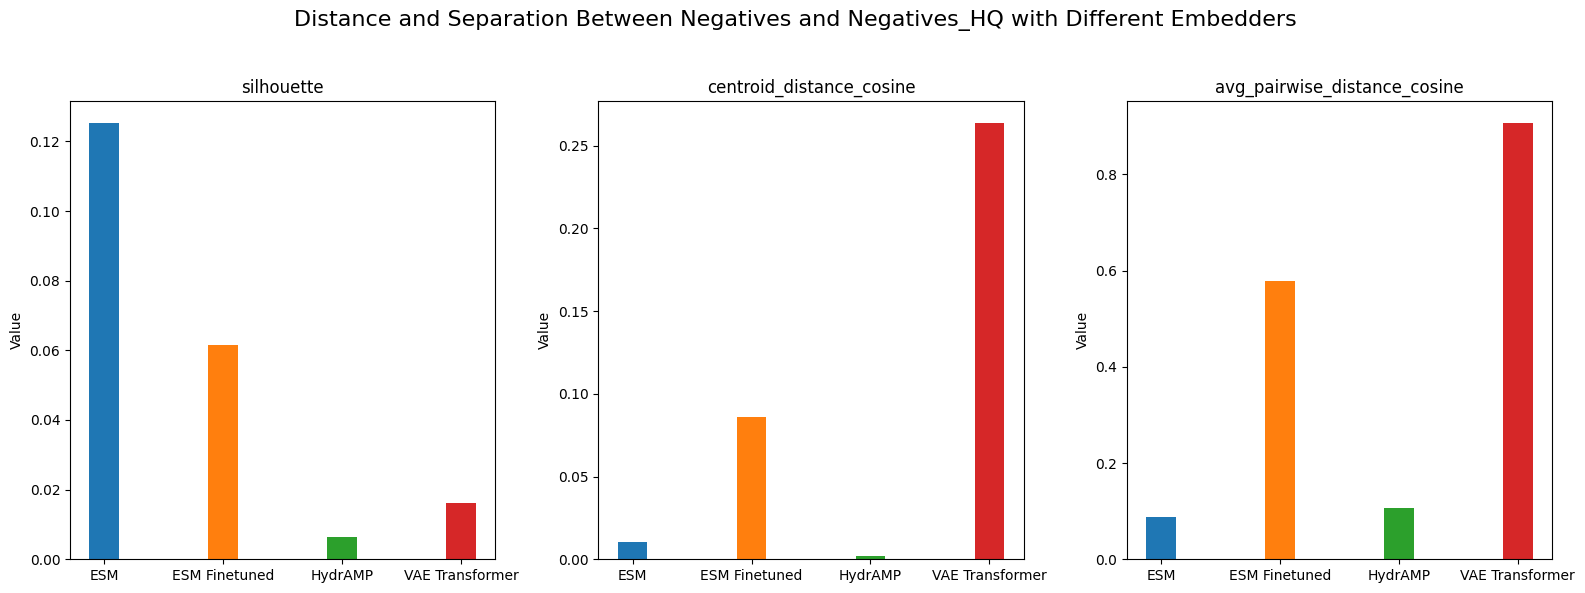

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['silhouette', 'centroid_distance_cosine', 'avg_pairwise_distance_cosine']

set_names = ['ESM', 'ESM Finetuned', 'HydrAMP', 'VAE Transformer']
values = {
    'ESM': [0.12524723, 0.01035881, 0.087311886],
    'ESM Finetuned': [0.06149297, 0.08585572, 0.5784274],
    'HydrAMP': [np.float32(0.006271987), np.float32(0.0016820431), np.float32(0.10612024)],
    'VAE Transformer': [np.float32(0.016198669), np.float32(0.26365244), np.float32(0.9067441)]
}

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
x = np.arange(len(metrics))
width = 0.25

for i, ax in enumerate(axes.flatten()):
    if i < len(metrics):
        metric = metrics[i]
        ax.bar(0, values['ESM'][i], width, label='ESM')
        ax.bar(1, values['ESM Finetuned'][i], width, label='ESM Finetuned')
        ax.bar(2, values['HydrAMP'][i], width, label='HydrAMP')
        ax.bar(3, values['VAE Transformer'][i], width, label='VAE Transformer')
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(['ESM', 'ESM Finetuned', 'HydrAMP', 'VAE Transformer'])
        ax.set_ylabel('Value')
        ax.set_title(metric)
    else:
        ax.axis('off')

fig.suptitle('Distance and Separation Between Negatives and Negatives_HQ with Different Embedders', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [18]:
a = {'silhouette': np.float32(0.009471213),'centroid_distance_cosine': np.float32(0.0035559535), 'avg_pairwise_distance_cosine': np.float32(0.107264414)}.values()
b = {'silhouette': np.float32(0.15680315), 'centroid_distance_cosine': np.float32(0.5363268), 'avg_pairwise_distance_cosine': np.float32(0.7977707)}.values()
c = {'silhouette': np.float32(0.0038057265), 'centroid_distance_cosine': np.float32(0.0008704066), 'avg_pairwise_distance_cosine': np.float32(0.104382664)}.values()
d = {'silhouette': np.float32(0.0044659707), 'centroid_distance_cosine': np.float32(0.054522038), 'avg_pairwise_distance_cosine': np.float32(0.84451807)}.values()

In [19]:
list(a)

[np.float32(0.009471213), np.float32(0.0035559535), np.float32(0.107264414)]

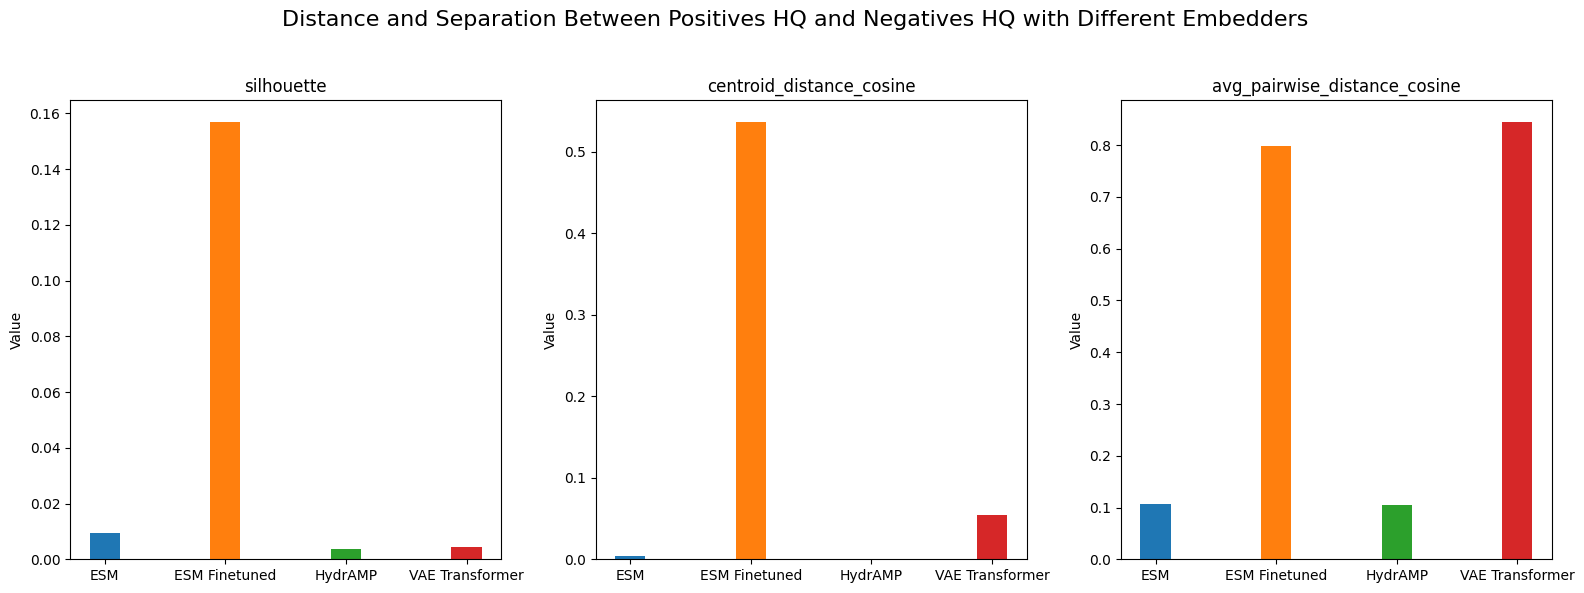

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['silhouette', 'centroid_distance_cosine', 'avg_pairwise_distance_cosine']

set_names = ['ESM', 'ESM Finetuned', 'HydrAMP', 'VAE Transformer']
values = {
    'ESM': list(a),
    'ESM Finetuned': list(b),
    'HydrAMP': list(c),
    'VAE Transformer': list(d)
}

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
x = np.arange(len(metrics))
width = 0.25

for i, ax in enumerate(axes.flatten()):
    if i < len(metrics): 
        metric = metrics[i]
        ax.bar(0, values['ESM'][i], width, label='ESM')
        ax.bar(1, values['ESM Finetuned'][i], width, label='ESM Finetuned')
        ax.bar(2, values['HydrAMP'][i], width, label='HydrAMP')
        ax.bar(3, values['VAE Transformer'][i], width, label='VAE Transformer')
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(['ESM', 'ESM Finetuned', 'HydrAMP', 'VAE Transformer'])
        ax.set_ylabel('Value')
        ax.set_title(metric)
    else:
        ax.axis('off')

fig.suptitle('Distance and Separation Between Positives HQ and Negatives HQ with Different Embedders', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 


In [ ]:
xs_tsne_esm = tsne(list(embeddings_esm.values()))
xs_tsne_esm_finetuned = tsne(list(embeddings_esm_finetuned.values()))
xs_tsne_hydramp = tsne(list(embeddings_hydramp.values()))
xs_tsne_vae_transformer = tsne(list(embeddings_vae_transformer.values()))

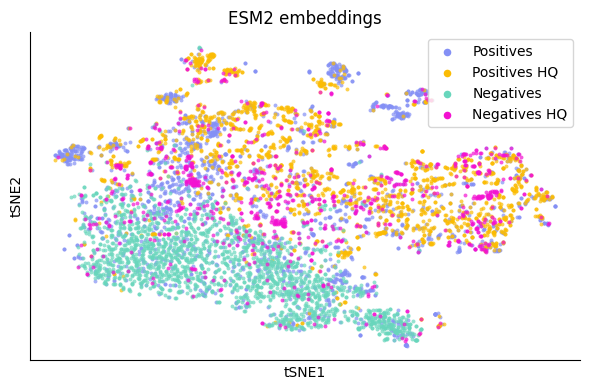

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_embeddings(
    xs_tsne_esm,
    title="ESM2 embeddings",
    colors=colors,
    alpha=0.7,
    point_size=8,
    legend_point_size=30,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    labels=['Positives', 'Positives HQ', 'Negatives', 'Negatives HQ']
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

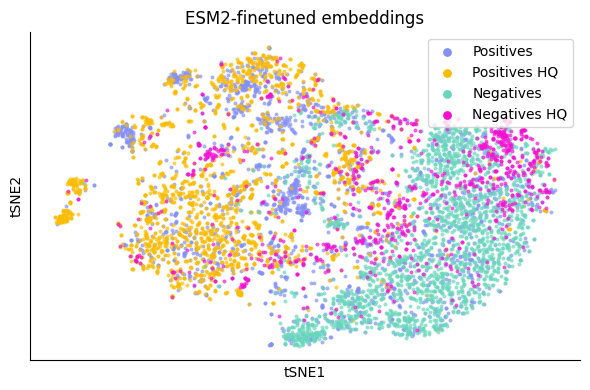

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_embeddings(
    xs_tsne_esm_finetuned,
    title = "ESM2-finetuned embeddings",
    colors=colors,
    alpha=0.7,
    point_size=8,
    legend_point_size=40,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    labels=['Positives', 'Positives HQ', 'Negatives', 'Negatives HQ']
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

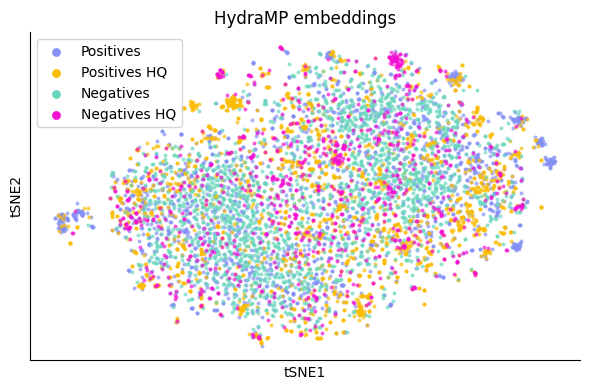

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_embeddings(
    xs_tsne_hydramp,
    title = "HydraMP embeddings",
    colors=colors,
    alpha=0.7,
    point_size=8,
    legend_point_size=40,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    labels=['Positives', 'Positives HQ', 'Negatives', 'Negatives HQ']
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

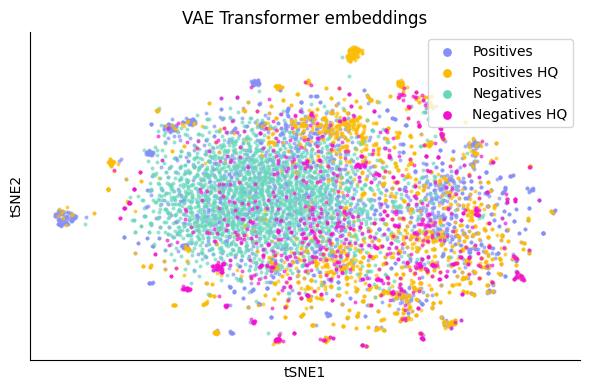

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_embeddings(
    xs_tsne_vae_transformer,
    title = "VAE Transformer embeddings",
    colors=colors,
    alpha=0.7,
    point_size=8,
    legend_point_size=40,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    labels=['Positives', 'Positives HQ', 'Negatives', 'Negatives HQ']
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dict_feature_means(data_dict):
    matrix = np.stack(list(data_dict.values()))
    mean_vector = matrix.mean(axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.hist(mean_vector, bins=100, edgecolor="black", alpha=0.7)
    plt.title("Histogram of Column-wise Mean Values")
    plt.xlabel("Mean value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
    
    return mean_vector


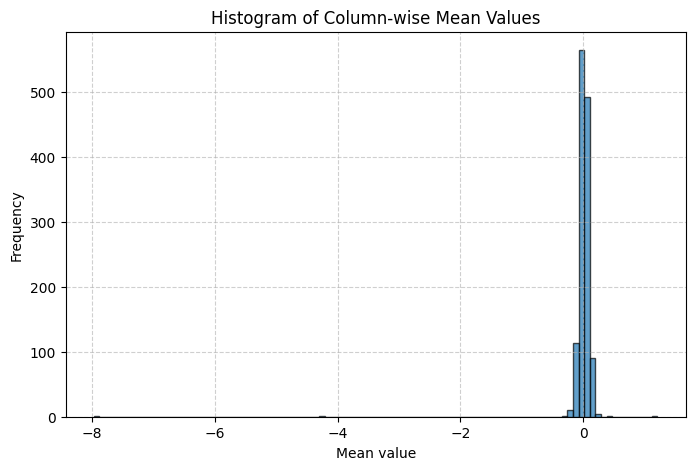

In [21]:
mean_vec = plot_dict_feature_means(cache.model_to_cache['esm2-embed'])

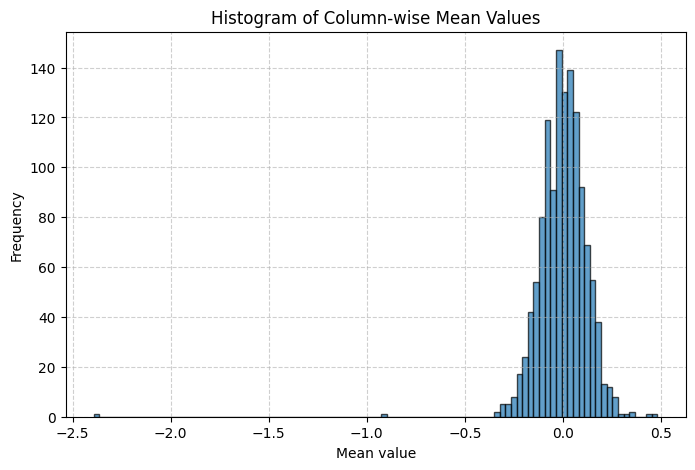

In [22]:
mean_vec = plot_dict_feature_means(cache.model_to_cache['esm2-pretrain'])